# PROBLEM STATEMENT


There is an *innovation competition* across the land, and the various
houses compete. All the ideas have been collected and scored, and now is the time
to calculate the results to find out the most innovative houses.

- The `innovation score` of a house is simply the `average scores` of all the ideas
submitted by people affiliated with this house. 

- Higher is better. 

- Ideas with no scores are excluded from consideration.

- Some people are affiliated with no house, in which case they should be counted as if in the house 'Free folk'.

- Some people are affiliated with more than one house, in which case the idea is credited to each and every one of the affiliated houses. For example, if user A is affiliated with houses X and Y, and they have submitted an idea that has a score of 5.7, both house X and Y will add a score of 5.7 in their tally.

## Input Data

The input data is two JSON files, and their EDN counterparts (containing the same data).

- `users.json` contains various users, each having an id first name, last name, email, and potentially a list of their house affiliation(s).

- `ideas.json` contains various ideas, each one having an id, a title, a body, an author-id (pointing to one entry in the `users.json` file) and an array of numeric scores. Unfortunately some scores were lost and were replaced by nulls. These scores should be ignored entirely.


## Expected output

The results should include:

- an list of the houses, from most innovative to least innovative
- the innovation score of each house
- the number of ideas submitted by each house



## Upload the given datasets

- `ideas.json`
- `users.json`

## Library Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

import warnings
warnings.filterwarnings("ignore")


## Read the datasets

### `users.json` dataset

In [3]:
users_df = pd.read_json("./users.json")
users_df.head(10)

,email,fname,house,id,lname
0,annabelle75@me.com,Olivia,NaN,user-32-0008735,Raymond
1,taylor@me.com,Sebastian,Lannister,user-76-0007445,Meyer
2,britt@hotmail.com,Aiden,NaN,user-06-0008566,Howell
3,easton@gmail.com,Jocelyn,NaN,user-74-0003086,Mitchell
4,carpenter@hotmail.com,Jack,Tully,user-30-0007697,Crane
5,dominic.warner@yahoo.com,Sarah,Targaryen,user-00-0009417,Donaldson
6,pratt@yahoo.com,Charlotte,Tyrell,user-14-0006746,Hickman
7,christian996@hotmail.com,Gabriella,Tully,user-62-0008441,Griffith
8,aaron638@me.com,Aaliyah,"[Lannister, Greyjoy]",user-20-0004583,Ware
9,jocelyn@gmail.com,Elizabeth,Greyjoy,user-95-0006252,Howard


In [4]:
# NOTE: Some people belong to two houses
users_df.iloc[8]

email         aaron638@me.com
fname                 Aaliyah
house    [Lannister, Greyjoy]
id            user-20-0004583
lname                    Ware
Name: 8, dtype: object

In [5]:
# General info about the dataset
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
email    500 non-null object
fname    500 non-null object
house    330 non-null object
id       500 non-null object
lname    500 non-null object
dtypes: object(5)
memory usage: 19.6+ KB


### `ideas.json` dataset

In [6]:
ideas_df = pd.read_json("./ideas.json")
ideas_df.head(10)

,author-id,body,id,scores,title
0,user-26-0005211,Omnis eum eos distinctio minima. Odio et natus...,idea-23-0003909,"[None, 5, 2]",Eius velit maiores molestiae error dolor odio ...
1,user-42-0007278,Eveniet voluptatum quis et at sed nesciunt fac...,idea-95-0003507,[2],Iusto adipisci illo voluptatem vel assumenda sit.
2,user-45-0005583,Ea voluptatem dicta delectus facere repellat v...,idea-62-0003354,[1],Iure et ut dolor optio rerum et quod debitis.
3,user-78-0008498,Necessitatibus deserunt iusto vitae autem occa...,idea-76-0007706,"[7, 1, 2, 8, 3, 5]",Non tenetur earum provident repellat deserunt.
4,user-23-0001583,Autem adipisci eos mollitia maiores sequi dolo...,idea-21-0008511,"[9, 6, 7, 8, 3]",Vel impedit vel omnis minus possimus explicabo...
5,user-05-0004617,Est amet perferendis consequatur quam accusant...,idea-64-0007805,"[None, 8]",Expedita sit vel vel quod.
6,user-94-0002159,Quam quisquam sint sit et suscipit fugiat exce...,idea-14-0007748,"[None, 2, 0]",Voluptate et assumenda ab et est sint recusandae.
7,user-46-0002967,Assumenda deserunt illum consequatur enim. Cor...,idea-92-0005095,"[2, 9, 6, 2, 9]",Iusto et provident totam voluptatem.
8,user-54-0009179,Magnam nulla esse placeat quos. Dolores nihil ...,idea-13-0000962,[9],Facilis quo rerum officiis dolorum eaque.
9,user-81-0004613,Laborum sit doloribus earum cum. Dolore repudi...,idea-04-0007915,"[5, 4, 8]",Magni magnam praesentium adipisci odio rerum.


In [7]:
# NOTE: There are some nil scores
ideas_df.iloc[0]['scores']

[None, 5, 2]

In [8]:
# General info about the dataset
ideas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 5 columns):
author-id    700 non-null object
body         700 non-null object
id           700 non-null object
scores       700 non-null object
title        700 non-null object
dtypes: object(5)
memory usage: 27.4+ KB


## Data Preparation

#### ideas_df

In [9]:
# There are no nil values in ideas data
ideas_df.isnull().sum()

author-id    0
body         0
id           0
scores       0
title        0
dtype: int64

In [10]:
# Function to clean the `score` list from NA value
def create_numeric_list(a_list):
    if a_list == None:
        return [0]
    elif a_list == [None]:
        return [0]
    else:
        return [n for n in a_list if type(n) == int ]

# Function to calculate the average score for an idea
def average_score(a_list):
    return np.average(create_numeric_list(a_list))



In [11]:
# Add a new column to the dataset
ideas_df['average_score'] =  ideas_df['scores'].apply(lambda x: average_score(x))
ideas_df.head()

,author-id,body,id,scores,title,average_score
0,user-26-0005211,Omnis eum eos distinctio minima. Odio et natus...,idea-23-0003909,"[None, 5, 2]",Eius velit maiores molestiae error dolor odio ...,3.500000
1,user-42-0007278,Eveniet voluptatum quis et at sed nesciunt fac...,idea-95-0003507,[2],Iusto adipisci illo voluptatem vel assumenda sit.,2.000000
2,user-45-0005583,Ea voluptatem dicta delectus facere repellat v...,idea-62-0003354,[1],Iure et ut dolor optio rerum et quod debitis.,1.000000
3,user-78-0008498,Necessitatibus deserunt iusto vitae autem occa...,idea-76-0007706,"[7, 1, 2, 8, 3, 5]",Non tenetur earum provident repellat deserunt.,4.333333
4,user-23-0001583,Autem adipisci eos mollitia maiores sequi dolo...,idea-21-0008511,"[9, 6, 7, 8, 3]",Vel impedit vel omnis minus possimus explicabo...,6.600000


In [12]:
# Drop the original `scores` as it's not needed anymore
ideas_df.drop(columns=['scores'], inplace=True)
ideas_df.head()

,author-id,body,id,title,average_score
0,user-26-0005211,Omnis eum eos distinctio minima. Odio et natus...,idea-23-0003909,Eius velit maiores molestiae error dolor odio ...,3.500000
1,user-42-0007278,Eveniet voluptatum quis et at sed nesciunt fac...,idea-95-0003507,Iusto adipisci illo voluptatem vel assumenda sit.,2.000000
2,user-45-0005583,Ea voluptatem dicta delectus facere repellat v...,idea-62-0003354,Iure et ut dolor optio rerum et quod debitis.,1.000000
3,user-78-0008498,Necessitatibus deserunt iusto vitae autem occa...,idea-76-0007706,Non tenetur earum provident repellat deserunt.,4.333333
4,user-23-0001583,Autem adipisci eos mollitia maiores sequi dolo...,idea-21-0008511,Vel impedit vel omnis minus possimus explicabo...,6.600000


In [13]:
# Keep only ideas with `average_score` more than 0 and drop the rest
ideas_df = ideas_df[ideas_df['average_score'] != 0]
ideas_df.head()

,author-id,body,id,title,average_score
0,user-26-0005211,Omnis eum eos distinctio minima. Odio et natus...,idea-23-0003909,Eius velit maiores molestiae error dolor odio ...,3.500000
1,user-42-0007278,Eveniet voluptatum quis et at sed nesciunt fac...,idea-95-0003507,Iusto adipisci illo voluptatem vel assumenda sit.,2.000000
2,user-45-0005583,Ea voluptatem dicta delectus facere repellat v...,idea-62-0003354,Iure et ut dolor optio rerum et quod debitis.,1.000000
3,user-78-0008498,Necessitatibus deserunt iusto vitae autem occa...,idea-76-0007706,Non tenetur earum provident repellat deserunt.,4.333333
4,user-23-0001583,Autem adipisci eos mollitia maiores sequi dolo...,idea-21-0008511,Vel impedit vel omnis minus possimus explicabo...,6.600000


In [14]:
# General info for the `ideas_df` in it's current state
ideas_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 672 entries, 0 to 699
Data columns (total 5 columns):
author-id        672 non-null object
body             672 non-null object
id               672 non-null object
title            672 non-null object
average_score    672 non-null float64
dtypes: float64(1), object(4)
memory usage: 31.5+ KB


#### `users_df`

In [15]:
# Some people don't have an associated `house`
users_df.isnull().sum()

email      0
fname      0
house    170
id         0
lname      0
dtype: int64

In [16]:
# Assign FreeFolk to people whith no house
users_df['house'].fillna("FreeFolk", inplace=True)
users_df.head()

,email,fname,house,id,lname
0,annabelle75@me.com,Olivia,FreeFolk,user-32-0008735,Raymond
1,taylor@me.com,Sebastian,Lannister,user-76-0007445,Meyer
2,britt@hotmail.com,Aiden,FreeFolk,user-06-0008566,Howell
3,easton@gmail.com,Jocelyn,FreeFolk,user-74-0003086,Mitchell
4,carpenter@hotmail.com,Jack,Tully,user-30-0007697,Crane


In [17]:
# Rename the `id` column to `author-id` for consistency with the `ideas_df` column names
users_df.rename(columns={'id':'author-id'}, inplace=True)
users_df.head()


,email,fname,house,author-id,lname
0,annabelle75@me.com,Olivia,FreeFolk,user-32-0008735,Raymond
1,taylor@me.com,Sebastian,Lannister,user-76-0007445,Meyer
2,britt@hotmail.com,Aiden,FreeFolk,user-06-0008566,Howell
3,easton@gmail.com,Jocelyn,FreeFolk,user-74-0003086,Mitchell
4,carpenter@hotmail.com,Jack,Tully,user-30-0007697,Crane


In [18]:
# Function to check for authors with multiple houses
def in_multiple_houses(x):
    if type(x) == list :
        return True
    else:
        return False


In [19]:
# Separate the users who belong to more than one house
users_with_double_house = users_df[users_df['house'].map(in_multiple_houses) == True]
users_with_double_house.head()

,email,fname,house,author-id,lname
8,aaron638@me.com,Aaliyah,"[Lannister, Greyjoy]",user-20-0004583,Ware
10,ian.hawkins@gmail.com,London,"[Targaryen, Greyjoy]",user-86-0004472,Rosales
11,ryder.bender@me.com,Aubree,"[Baratheon, Lannister]",user-84-0006286,Hart
24,sweeney@yahoo.com,Brandon,"[Baratheon, Tyrell]",user-81-0009552,Douglas
25,mcdowell@hotmail.com,Gabriel,"[Stark, Targaryen]",user-31-0000558,Madden


In [20]:
# Info about users belonging to double houses
users_with_double_house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140 entries, 8 to 499
Data columns (total 5 columns):
email        140 non-null object
fname        140 non-null object
house        140 non-null object
author-id    140 non-null object
lname        140 non-null object
dtypes: object(5)
memory usage: 6.6+ KB


In [21]:
# Separate the users who only belong to a single house
users_with_single_house = users_df[users_df['house'].map(in_multiple_houses) == False]
users_with_single_house.head()

,email,fname,house,author-id,lname
0,annabelle75@me.com,Olivia,FreeFolk,user-32-0008735,Raymond
1,taylor@me.com,Sebastian,Lannister,user-76-0007445,Meyer
2,britt@hotmail.com,Aiden,FreeFolk,user-06-0008566,Howell
3,easton@gmail.com,Jocelyn,FreeFolk,user-74-0003086,Mitchell
4,carpenter@hotmail.com,Jack,Tully,user-30-0007697,Crane


In [22]:
# 360 users belong to a single house
users_with_single_house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 360 entries, 0 to 498
Data columns (total 5 columns):
email        360 non-null object
fname        360 non-null object
house        360 non-null object
author-id    360 non-null object
lname        360 non-null object
dtypes: object(5)
memory usage: 16.9+ KB


In [23]:
# A function which takes the pd.Series of a user with 2 houses and normalizes them \
# in 2 pd.Series with a single house

def split_double_houses(a_series):
  a_data_dict = a_series.to_dict()
  var = []
  houses = a_data_dict['house']
  var.append(a_data_dict.copy())
  var[0]['house'] = houses[0]
  var.append(a_data_dict.copy())
  var[1]['house'] = houses[1]
  temp =  pd.DataFrame([pd.Series(var[0], index=a_series.index), \
                        pd.Series(var[1], index=a_series.index)], \
                       columns= a_series.index)
  return temp



In [24]:
# Create a new normalized dataframe containing using the `split_double_houses` functions on `users_with_double_houses` dataframe

normalized_users_with_double_houses = pd.DataFrame()

for index, row in users_with_double_house.iterrows():
    normalized_users_with_double_houses = normalized_users_with_double_houses.append(split_double_houses(row))

normalized_users_with_double_houses.head()

,email,fname,house,author-id,lname
0,aaron638@me.com,Aaliyah,Lannister,user-20-0004583,Ware
1,aaron638@me.com,Aaliyah,Greyjoy,user-20-0004583,Ware
0,ian.hawkins@gmail.com,London,Targaryen,user-86-0004472,Rosales
1,ian.hawkins@gmail.com,London,Greyjoy,user-86-0004472,Rosales
0,ryder.bender@me.com,Aubree,Baratheon,user-84-0006286,Hart


In [25]:
# Create a new dataframe with only one individual per house
final_users_df = pd.concat([users_with_single_house, normalized_users_with_double_houses])
final_users_df.head()


,email,fname,house,author-id,lname
0,annabelle75@me.com,Olivia,FreeFolk,user-32-0008735,Raymond
1,taylor@me.com,Sebastian,Lannister,user-76-0007445,Meyer
2,britt@hotmail.com,Aiden,FreeFolk,user-06-0008566,Howell
3,easton@gmail.com,Jocelyn,FreeFolk,user-74-0003086,Mitchell
4,carpenter@hotmail.com,Jack,Tully,user-30-0007697,Crane


In [26]:
# General info for the finalized users dataframe
final_users_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 640 entries, 0 to 1
Data columns (total 5 columns):
email        640 non-null object
fname        640 non-null object
house        640 non-null object
author-id    640 non-null object
lname        640 non-null object
dtypes: object(5)
memory usage: 30.0+ KB


## Analysis


### Number of ideas that people have contributed in the competition

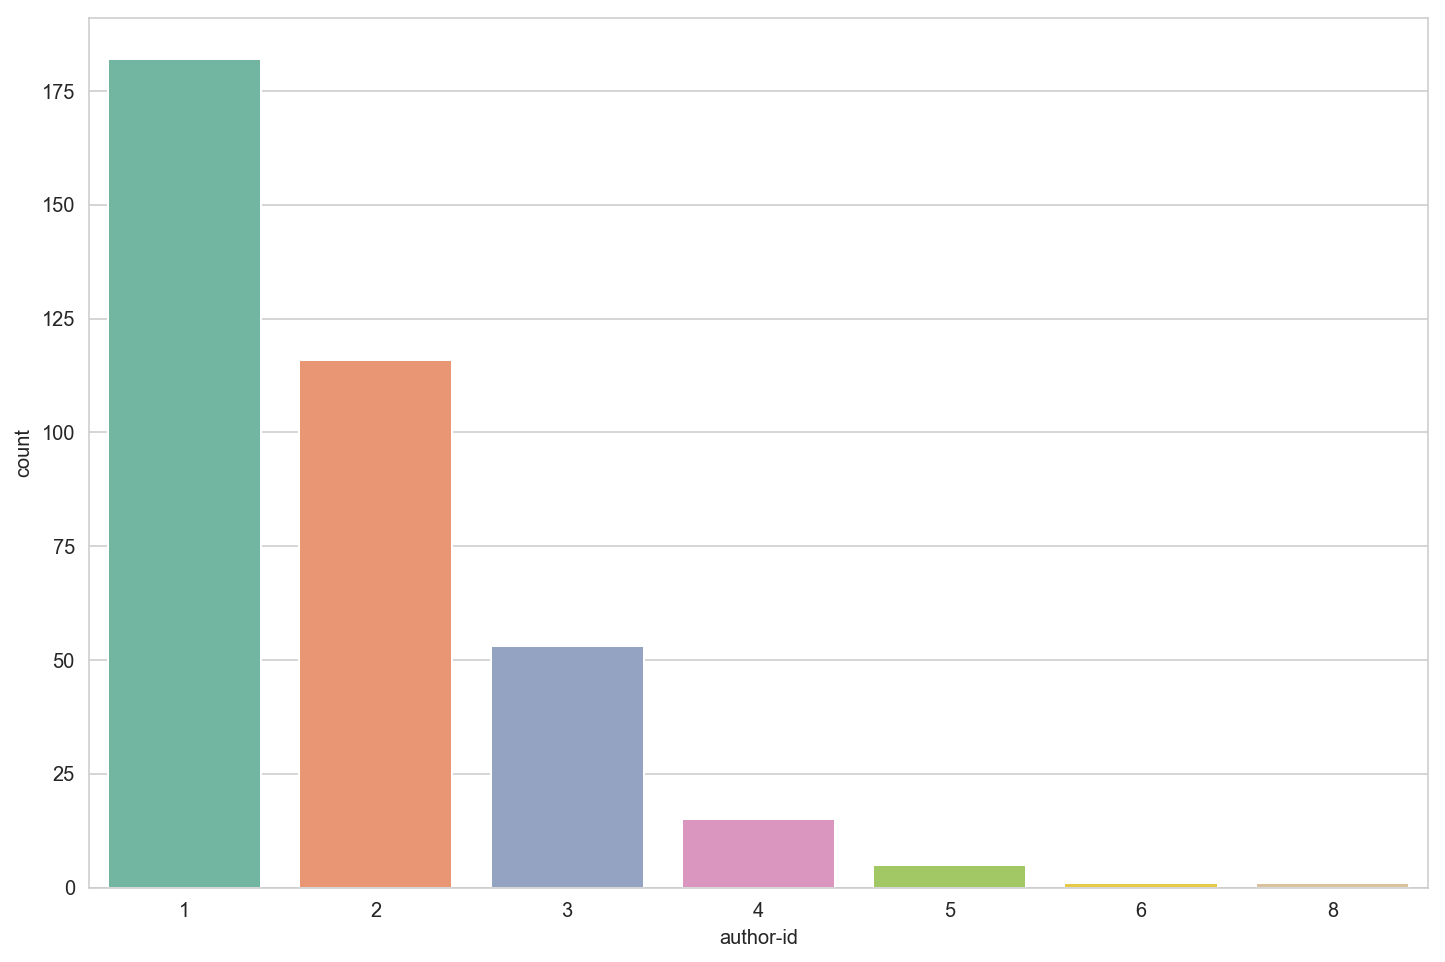

In [27]:
# Some people have contributed multiple ideas, though most have contribute either 1 or 2
plt.figure(figsize=(12,8))
sns.set_palette(sns.color_palette("Set2", 10))
sns.set_style("whitegrid")
sns.countplot(ideas_df['author-id'].value_counts())

## Merge the `final_users_df` and `ideas_df` datasets for a complete picture of the competition

In [28]:
users_ideas_merged_df = pd.merge(final_users_df, ideas_df, on='author-id')

users_ideas_merged_df.head()

,email,fname,house,author-id,lname,body,id,title,average_score
0,annabelle75@me.com,Olivia,FreeFolk,user-32-0008735,Raymond,Pariatur vel aliquam quibusdam ipsam.,idea-15-0002513,Aut est quibusdam dolor unde odio ut perspicia...,2.166667
1,annabelle75@me.com,Olivia,FreeFolk,user-32-0008735,Raymond,Et et adipisci et mollitia ut veniam inventore...,idea-90-0005654,Cumque cum aliquid asperiores aut occaecati.,3.000000
2,annabelle75@me.com,Olivia,FreeFolk,user-32-0008735,Raymond,Sit qui eos quasi laudantium et nostrum optio.,idea-98-0001094,Asperiores perspiciatis sed perferendis qui ev...,4.333333
3,taylor@me.com,Sebastian,Lannister,user-76-0007445,Meyer,Et voluptatem reprehenderit consequatur adipis...,idea-91-0001645,Commodi aut temporibus sit aspernatur odio at.,4.600000
4,britt@hotmail.com,Aiden,FreeFolk,user-06-0008566,Howell,Fuga temporibus nostrum modi officia optio id ...,idea-05-0009556,Qui suscipit rerum ut quam.,7.000000


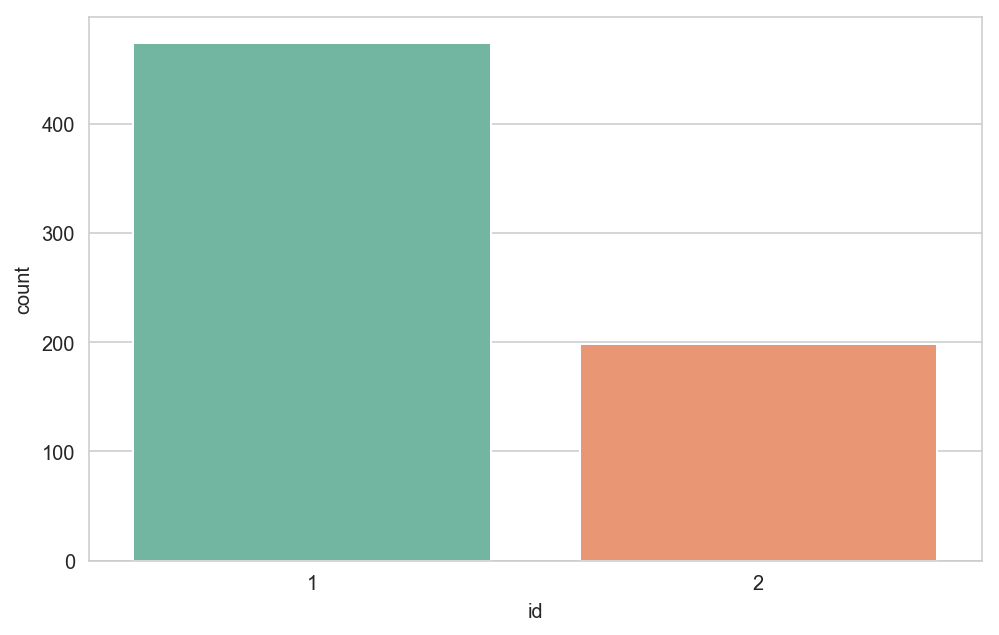

In [29]:
# NOTE: There is a repetition of ideas now since a user with two houses who contributed a single idea is now \
# treated as two distinct users belonging to a unique house, who have contributed a single idea.
sns.set_palette(sns.color_palette("Set2", 10))
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))
sns.countplot(users_ideas_merged_df['id'].value_counts())

### Explanation of `users_ideas_merged_df`.

`Aubrey Carlson` with `author-id` of `user-94-0002159` has contributed three distinct ideas `idea-51-0000624`, `idea-14-0007748` and `idea-54-0003131`.

However, since she belongs to two houses `Martell` and `Baratheon`, for our analysis we will consider that `Aubrey Carlson of house Martell` contributed 3 ideas and `Aubrey Carlson of house Baratheon` contributed 3 ideas.

In [30]:
# Gives use the "unique" users who contribtued to an idea.
users_ideas_merged_df.loc[users_ideas_merged_df['id'] == 'idea-51-0000624']

,email,fname,house,author-id,lname,body,id,title,average_score
691,avery@me.com,Aubrey,Martell,user-94-0002159,Carlson,Temporibus perferendis eius veniam tenetur lib...,idea-51-0000624,Numquam architecto qui itaque molestias deseru...,6.0
694,avery@me.com,Aubrey,Baratheon,user-94-0002159,Carlson,Temporibus perferendis eius veniam tenetur lib...,idea-51-0000624,Numquam architecto qui itaque molestias deseru...,6.0


In [31]:
# Gives us the combination of "unique" user-idea after normalization and mergnign
users_ideas_merged_df.loc[users_ideas_merged_df['author-id'] == 'user-94-0002159']

,email,fname,house,author-id,lname,body,id,title,average_score
690,avery@me.com,Aubrey,Martell,user-94-0002159,Carlson,Quam quisquam sint sit et suscipit fugiat exce...,idea-14-0007748,Voluptate et assumenda ab et est sint recusandae.,1.000000
691,avery@me.com,Aubrey,Martell,user-94-0002159,Carlson,Temporibus perferendis eius veniam tenetur lib...,idea-51-0000624,Numquam architecto qui itaque molestias deseru...,6.000000
692,avery@me.com,Aubrey,Martell,user-94-0002159,Carlson,Corrupti eaque cum libero incidunt. Libero eli...,idea-54-0003131,Dolorem perferendis quia quo perspiciatis sit ...,4.166667
693,avery@me.com,Aubrey,Baratheon,user-94-0002159,Carlson,Quam quisquam sint sit et suscipit fugiat exce...,idea-14-0007748,Voluptate et assumenda ab et est sint recusandae.,1.000000
694,avery@me.com,Aubrey,Baratheon,user-94-0002159,Carlson,Temporibus perferendis eius veniam tenetur lib...,idea-51-0000624,Numquam architecto qui itaque molestias deseru...,6.000000
695,avery@me.com,Aubrey,Baratheon,user-94-0002159,Carlson,Corrupti eaque cum libero incidunt. Libero eli...,idea-54-0003131,Dolorem perferendis quia quo perspiciatis sit ...,4.166667


# Results

### A list of the houses, from most innovative to least innovative


In [31]:
users_ideas_merged_df['house'].value_counts().index.to_list()


['FreeFolk',
 'Baratheon',
 'Targaryen',
 'Greyjoy',
 'Martell',
 'Tully',
 'Tyrell',
 'Stark',
 'Lannister']

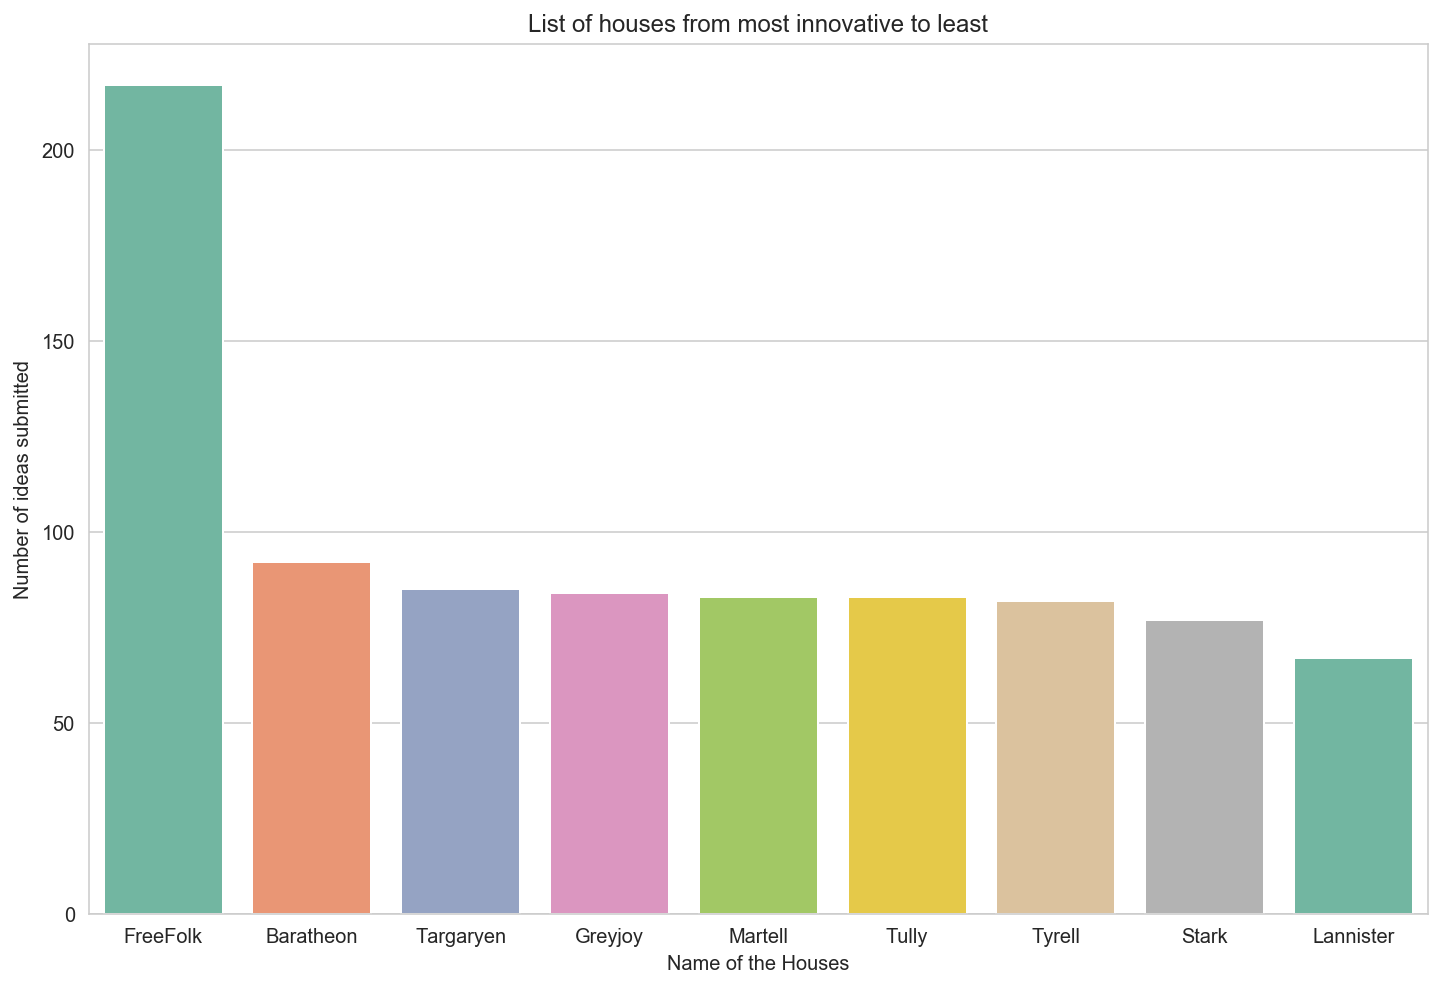

In [32]:
plt.figure(figsize=(12,8))
plt.title('List of houses from most innovative to least')
sns.set_palette(sns.color_palette("Set2", 10))
sns.set_style("whitegrid")
ax = sns.countplot(x = 'house', data = users_ideas_merged_df, order= users_ideas_merged_df['house'].value_counts().index)
ax.set(ylabel='Number of ideas submitted', xlabel='Name of the Houses')
plt.show()
              

###  The innovation score of each house


In [33]:
# Function that calculates the average of all the ideas contributed by a house

def innovation_score_of_house(a_house):
  house_df = users_ideas_merged_df[users_ideas_merged_df['house'] == a_house]
  return house_df[['average_score']].mean()[0]


In [34]:
# Prints the average score of all ideas associated with a house

names_of_houses = users_ideas_merged_df['house'].value_counts().index.to_list()

innovation_scores_dict = dict()

for a_house in names_of_houses: 
  innovation_scores_dict[a_house] = innovation_score_of_house(a_house)

innovation_scores_dict

{'Baratheon': 4.729347826086956,
 'FreeFolk': 4.7847158218125925,
 'Greyjoy': 4.5125,
 'Lannister': 4.599253731343283,
 'Martell': 5.013253012048193,
 'Stark': 4.715584415584415,
 'Targaryen': 4.529215686274509,
 'Tully': 4.6969879518072295,
 'Tyrell': 4.583943089430895}

In [35]:
# Houses sorted by their innovation scores

innovation_scores_series = pd.Series(innovation_scores_dict, index=names_of_houses).sort_values(ascending=False)
innovation_scores_series


Martell      5.013253
FreeFolk     4.784716
Baratheon    4.729348
Stark        4.715584
Tully        4.696988
Lannister    4.599254
Tyrell       4.583943
Targaryen    4.529216
Greyjoy      4.512500
dtype: float64

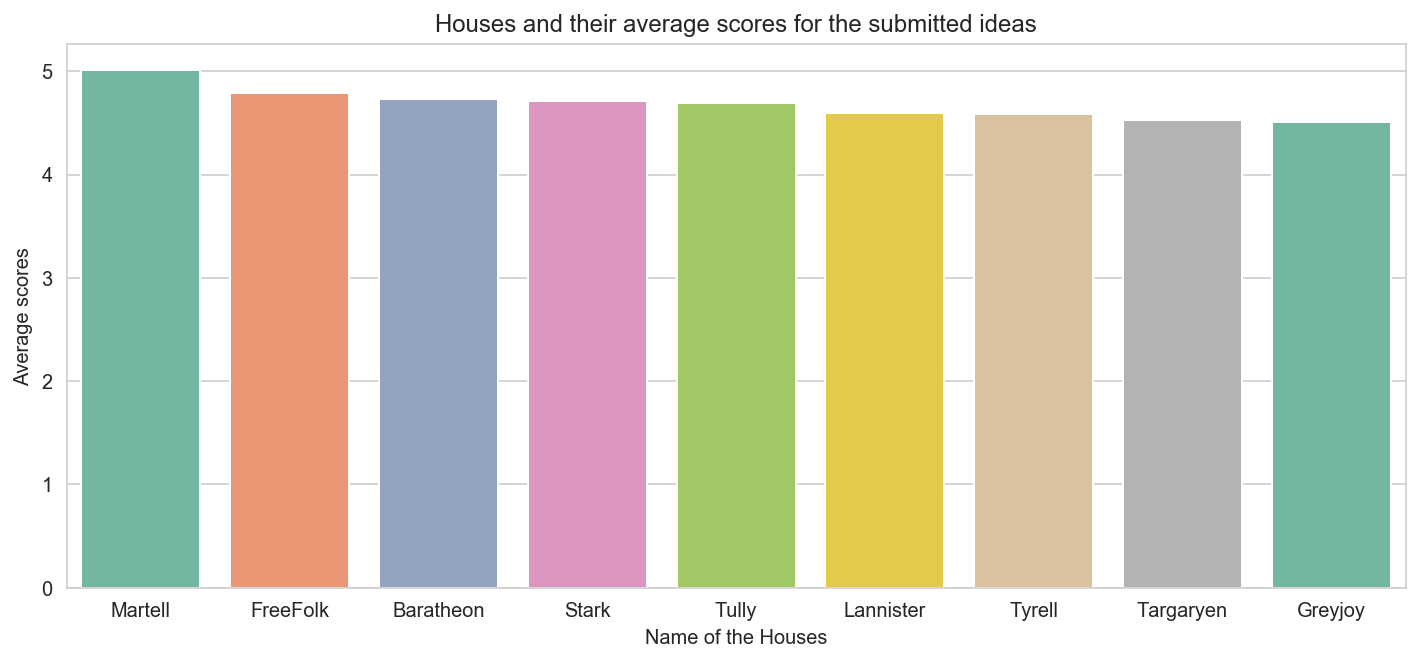

In [36]:

plt.figure(figsize=(12,5))
plt.title('Houses and their average scores for the submitted ideas')
sns.set_palette(sns.color_palette("Set2", 10))
sns.set_style("whitegrid")
ax = sns.barplot(x= innovation_scores_series.index, y= innovation_scores_series.values)
ax.set(ylabel='Average scores', xlabel='Name of the Houses')
plt.show()
             

### The number of ideas submitted by each house


In [37]:
users_ideas_merged_df['house'].value_counts()


FreeFolk     217
Baratheon     92
Targaryen     85
Greyjoy       84
Martell       83
Tully         83
Tyrell        82
Stark         77
Lannister     67
Name: house, dtype: int64